In [ ]:
class util_vars:

    window_size=200
    forecast_window=10
    kernel_sz = 4
    nb_filter = 5
    dilation_rates = [2**i for i in range(8)]
    nb_epoch = 20
    batch_size = 500
    dense_activations = ['sigmoid','relu','relu','sigmoid','sigmoid']
    loss_functions = ['categorical_crossentropy', 'mse', 'mse', 'categorical_crossentropy', 'categorical_crossentropy']
    model_metrics = ['accuracy', 'mse', 'mse', 'accuracy', 'accuracy']
    output_sizes = [3,1,1,2,2]


    # Init
    def __init__(self):
        self.mean = np.arange(5)
        self.std = np.arange(5)


    def get_mean(self):
        return self.mean


    def set_mean(self, mean):
        self.mean = mean


    def get_std(self):
        return self.std


    def set_std(self, std):
        return self.std


    # Make time-series instance
    def make_timeseries_instances(self, timeseries, window_size, forecast_window):
        timeseries = np.asarray(timeseries)
        assert 0 < window_size < timeseries.shape[0]
        X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size-forecast_window, 1)]))
        y = timeseries[window_size:] # Change this if output size is to change too
        y = np.array([y[start:start+forecast_window] for start in range(0,y.shape[0]-forecast_window, 1)])
        q = np.atleast_3d([timeseries[-window_size:]])
        return X, y, q


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
%matplotlib inline
import math
# Import utils
# import util_vars

# All vars|
util = util_vars()

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape, Dropout, concatenate, GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed
from keras.utils import plot_model

Using TensorFlow backend.


# Is tensorflow using GPU? Convert to code cell to check.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
import pywt
wavelet = pywt.Wavelet('db1')

In [9]:
# Read Data
dataset = pd.read_excel('/content/drive/My Drive/FALCON-DP/normal.xlsx')
full_attack = pd.read_excel('/content/drive/My Drive/FALCON-DP/attack.xlsx')
full_attack = full_attack.drop(full_attack.index[230310:264238]).reset_index(drop=True)
full_attack.columns

Index([' Timestamp', 'FIT101', 'LIT101', ' MV101', 'P101', 'P102', ' AIT201',
       'AIT202', 'AIT203', 'FIT201', ' MV201', ' P201', ' P202', 'P203',
       ' P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301',
       'MV302', ' MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402',
       'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501',
       'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504',
       'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602',
       'P603', 'Normal/Attack'],
      dtype='object')

In [ ]:
dataset['Normal/Attack'] = dataset['Normal/Attack'].apply(lambda x: 0 if 'N' in x else 1)
full_attack['Normal/Attack'] = full_attack['Normal/Attack'].apply(lambda x: 0 if 'N' in x else 1)
normal_data = dataset.values[16000:, 1:].astype('float16') #Only need data after first 16,000
attack_data = full_attack.values[:, 1:].astype('float16')
full_attack = None
dataset = None

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Get labels
y_labels_attack = attack_data[:, -1].astype('int')
normal_data = normal_data[:, :-1]
attack_data = attack_data[:, :-1]
normal_data.shape, attack_data.shape

((479000, 51), (415991, 51))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
test_size = int(normal_data.shape[0]*0.5)
scaler = scaler.fit(normal_data[:-test_size,:])
attack_scaled = scaler.transform(attack_data)
normal_data = None
attack_data = None
attack_scaled.shape

(415991, 51)

In [ ]:
util.window_size = 200
util.forecast_window = 1
util.nb_filter = 5
util.nb_epoch = 100

In [ ]:
# Time Window Build of Data
normal_scaled = None
X = np.atleast_3d(np.array([attack_scaled[start:start + util.window_size] for start in range(0, attack_scaled.shape[0] - util.window_size-util.forecast_window, 1)]))
y = y_labels_attack[util.window_size+1:]
y.shape, X.shape

((415790,), (415790, 200, 51))

In [ ]:
from tqdm import tqdm as tqdm

In [ ]:
arr = np.zeros((415790,200,102))
for i, elm in enumerate(tqdm(X)):
    cA, cD = pywt.dwt(X[i].reshape(51,200), wavelet=wavelet, mode='periodic')
    arr[i] = np.concatenate((X[i],np.concatenate((cA, cD), axis=1).reshape(200,51)), axis=1)

100%|██████████| 415790/415790 [01:34<00:00, 4385.37it/s]


In [ ]:
np.savez('data.npz', X=X, y=y)

In [ ]:
# Comment this out to load data directly
# dat = np.load('data.npz')
# X = dat['X']
# y = dat['y']
# dat = None

In [ ]:
# Train - Test split for time window
X = arr
train_size = int(X.shape[0]*0.6)
X_train, X_test = X[:-train_size], X[-train_size:]
y_train, y_test = y[:-train_size], y[-train_size:]
full_X_train, full_X_test = attack_scaled[util.window_size+1:-train_size], attack_scaled[-train_size:]
X_test.shape, X_train.shape, y_test.shape, y_train.shape, full_X_test.shape, full_X_train.shape

((249474, 200, 102),
 (166316, 200, 102),
 (249474,),
 (166316,),
 (249474, 51),
 (166316, 51))

In [ ]:
full_X_train_t = full_X_train.reshape(full_X_train.shape[0], 1, full_X_train.shape[1])
full_X_valid_t = full_X_train.reshape(full_X_train.shape[0], 1, full_X_train.shape[1])

In [ ]:
util.nb_epoch = 30

In [ ]:
def multi_input(input_, full):
    x = Input(shape=(util.window_size, X_train.shape[2]), name='window_input')
    
    cnn_out = Dense(100)(x)
    cnn_out = Conv1D(filters=util.nb_filter, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=2)(cnn_out)
    cnn_out = MaxPooling1D()(cnn_out)
    cnn_out = Conv1D(filters=util.nb_filter*2, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=4)(cnn_out)
    cnn_out = MaxPooling1D()(cnn_out)    
    cnn_out = Conv1D(filters=util.nb_filter*3, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=8)(cnn_out)
    cnn_out = MaxPooling1D()(cnn_out)
    cnn_out = Conv1D(filters=util.nb_filter*4, kernel_size=4, activation='relu',
               padding='causal', dilation_rate=16)(cnn_out)
    cnn_out = GlobalMaxPooling1D()(cnn_out)
#     cnn_out = Conv1D(filters=util.nb_filter*5, kernel_size=4, activation='relu',
#                padding='causal', dilation_rate=16)(cnn_out)
#     cnn_out = GlobalMaxPooling1D()(cnn_out)
    
    # Non time-window input
    input_full = Input(shape=(1,full.shape[1]), name='full_input')
    lstm_out = LSTM(128, return_sequences=True)(input_full)
    lstm_out = LSTM(128)(lstm_out)
#     lstm_out = LSTM(util.nb_filter*4)(lstm_out)
    
    # Concat LSTM out and y
    y = concatenate([lstm_out, cnn_out])
#     y = Reshape((int(util.nb_filter*4/normal_data.shape[1])*2,normal_data.shape[1]))(y)
    y = Dropout(0.2)(y)
#     y = TimeDistributed(Dense(normal_data.shape[1], activation='sigmoid', name='main_output'))(y)
    y = Dense(64, activation='sigmoid')(y)
    output = Dense(1, activation='sigmoid', name='main_output')(y)
    
    model = Model(inputs=[x, input_full], outputs=output, name='cnn_lstm_model')
    return model


multi_model = multi_input(input_=X_train, full=full_X_train)
#plot_model(multi_model, "test.png", show_shapes=True)
#Image(retina=True, filename='test.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# Compile Model
multi_model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [ ]:
from collections import Counter
def get_class_weights(y, smooth_factor=0):
    counter = Counter(y)
    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p
    majority = max(counter.values())
    return {cls: float(majority / count) for cls, count in counter.items()}


class_weights = get_class_weights(y_train, smooth_factor = 0)
class_weights

{0: 1.0, 1: 16.732807335536837}

In [ ]:
# Save model to disk
def save_model_to_disk(model_, name="model"):
    model_.save(name+'.h5')
    print("----- {0} SAVED TO DISK ----".format(name))

In [ ]:
multi_model.fit({'window_input':X_train, 'full_input':full_X_train_t}, y_train, epochs=util.nb_epoch, 
                class_weight=class_weights, batch_size=util.batch_size)

save_model_to_disk(multi_model, name="wavenetCNNLSTM_1")

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30
166316/166316 [==============================] - 166s 997us/step - loss: 0.6491 - acc: 0.8187
Epoch 2/30
166316/166316 [==============================] - 47s 280us/step - loss: 0.3014 - acc: 0.9095
Epoch 3/30
166316/166316 [==============================] - 47s 280us/step - loss: 0.1866 - acc: 0.9446
Epoch 4/30
166316/166316 [==============================] - 47s 281us/step - loss: 0.1532 - acc: 0.9559
Epoch 5/30
166316/166316 [==============================] - 47s 281us/step - loss: 0.1345 - acc: 0.9624
Epoch 6/30
166316/166316 [==============================] - 47s 282us/step - loss: 0.1144 - acc: 0.9678
Epoch 7/30
166316/166316 [==============================] - 47s 281us/step - loss: 0.0916 - acc: 0.9750
Epoch 8/30
166316/166316 [==============================] - 47s 281us/step - loss: 0.0885 - acc: 0.9758
Epoch 9/30
166316/166316 [===============

In [ ]:
predictions = multi_model.predict([X_test, full_X_test.reshape(full_X_test.shape[0], 1, full_X_test.shape[1])])

In [ ]:
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

In [ ]:
y_test.shape

(249474,)

In [ ]:
from sklearn.metrics import recall_score
recall_score(predictions.reshape(predictions.shape[0],), y_test)

0.5260496475635917

In [ ]:
np.unique(predictions)

array([0., 1.], dtype=float32)

In [ ]:
plt.plot(y_test)

In [ ]:
plt.plot(predictions)

In [ ]:
from keras.models import load_model
multi_model = load_model('wavenetCNNLSTM_1.h5')
full_X = attack_scaled.reshape(attack_scaled.shape[0], 1, attack_scaled.shape[1])
predictions = multi_model.predict([X, full_X])

In [ ]:
predictions[predictions>=0.95] = 1
predictions[predictions<0.95] = 0

In [ ]:
predictions.astype('int64')

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [ ]:
from sklearn.metrics import recall_score, f1_score, precision_score
print(recall_score(predictions.reshape(predictions.shape[0],).astype('int64'), y))
print(precision_score(predictions.reshape(predictions.shape[0],).astype('int64'), y))
f1_score(predictions.reshape(predictions.shape[0],).astype('int64'), y)

0.6836299539432535
0.5670423996604255


0.6199020366073731

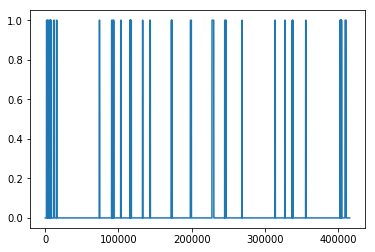

In [ ]:
plt.plot(y)

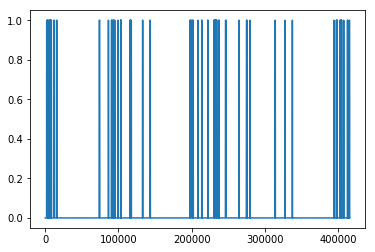

In [ ]:
plt.plot(predictions)

In [ ]:
test_ = 411062
test_ = test_ + np.where(y[test_:]==1)[0]
test_

array([], dtype=int64)

In [ ]:
test_1 = test_[0]
test_1 + np.where(y[test_1:]==0)[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
i=1
print(1, recall_score(predictions[1553:2493], y[1553:2493]))
print(2, recall_score(predictions[2867:3310], y[2867:3310]))
print(3, recall_score(predictions[4719:5102], y[4719:5102]))
print(4, recall_score(predictions[6258:6648], y[6258:6648]))
print(5, recall_score(predictions[7054:7250], y[7054:7250]))
print(6, recall_score(predictions[7504:7933], y[7504:7933]))
print(7, recall_score(predictions[11209:12173], y[11209:12173]))
print(8, recall_score(predictions[15179:15900], y[15179:15900]))
print(9, recall_score(predictions[73599:74320], y[73599:74320]))
print(10, recall_score(predictions[90484:90717], y[90484:90717]))
print(11, recall_score(predictions[91939:92370], y[91939:92370]))
print(12, recall_score(predictions[93244:93520], y[93244:93520]))
print(13, recall_score(predictions[102891:103608], y[102891:103608]))
print(14, recall_score(predictions[115642:115901], y[115642:115901]))
print(15, recall_score(predictions[115942:116337], y[115942:116337]))
print(16, recall_score(predictions[116799:117520], y[116799:117520]))
print(17, recall_score(predictions[132717:133180], y[132717:133180]))
print(18, recall_score(predictions[142753:143450], y[142753:143450]))
print(19, recall_score(predictions[172067:172388], y[172067:172388]))
print(20, recall_score(predictions[172709:173321], y[172709:173321]))
print(21, recall_score(predictions[198095:199540], y[198095:199540]))
print(22, recall_score(predictions[227627:230109], y[227627:230109]))
print(23, recall_score(predictions[244991:245112], y[244991:245112]))
print(24, recall_score(predictions[245931:247102], y[245931:247102]))
print(25, recall_score(predictions[268524:268891], y[268524:268891]))
print(26, recall_score(predictions[313550:314151], y[313550:314151]))
print(27, recall_score(predictions[327062:327506], y[327062:327506]))
print(28, recall_score(predictions[337350:337451], y[337350:337451]))
print(29, recall_score(predictions[337726:338207], y[337726:338207]))
print(30, recall_score(predictions[355551:356091], y[355551:356091]))
print(31, recall_score(predictions[402412:402881], y[402412:402881]))
print(32, recall_score(predictions[404018:404419], y[404018:404419]))
print(33, recall_score(predictions[404492:404789], y[404492:404789]))
print(34, recall_score(predictions[409372:411062], y[409372:411062]))

1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0
15 1.0
16 1.0
17 1.0
18 1.0
19 0.0
20 0.0
21 1.0
22 0.0
23 0.0
24 1.0
25 0.0
26 1.0
27 1.0
28 0.0
29 0.0
30 0.0
31 1.0
32 1.0
33 1.0
34 0.0


In [ ]:
print(1, precision_score(predictions[1553:2493], y[1553:2493]))
print(2, precision_score(predictions[2867:3310], y[2867:3310]))
print(3, precision_score(predictions[4719:5102], y[4719:5102]))
print(4, precision_score(predictions[6258:6648], y[6258:6648]))
print(5, precision_score(predictions[7054:7250], y[7054:7250]))
print(6, precision_score(predictions[7504:7933], y[7504:7933]))
print(7, precision_score(predictions[11209:12173], y[11209:12173]))
print(8, precision_score(predictions[15179:15900], y[15179:15900]))
print(9, precision_score(predictions[73599:74320], y[73599:74320]))
print(10, precision_score(predictions[90484:90717], y[90484:90717]))
print(11, precision_score(predictions[91939:92370], y[91939:92370]))
print(12, precision_score(predictions[93244:93520], y[93244:93520]))
print(13, precision_score(predictions[102891:103608], y[102891:103608]))
print(14, precision_score(predictions[115642:115901], y[115642:115901]))
print(15, precision_score(predictions[115942:116337], y[115942:116337]))
print(16, precision_score(predictions[116799:117520], y[116799:117520]))
print(17, precision_score(predictions[132717:133180], y[132717:133180]))
print(18, precision_score(predictions[142753:143450], y[142753:143450]))
print(19, precision_score(predictions[172067:172388], y[172067:172388]))
print(20, precision_score(predictions[172709:173321], y[172709:173321]))
print(21, precision_score(predictions[198095:199540], y[198095:199540]))
print(22, precision_score(predictions[227627:230109], y[227627:230109]))
print(23, precision_score(predictions[244991:245112], y[244991:245112]))
print(24, precision_score(predictions[245931:247102], y[245931:247102]))
print(25, precision_score(predictions[268524:268891], y[268524:268891]))
print(26, precision_score(predictions[313550:314151], y[313550:314151]))
print(27, precision_score(predictions[327062:327506], y[327062:327506]))
print(28, precision_score(predictions[337350:337451], y[337350:337451]))
print(29, precision_score(predictions[337726:338207], y[337726:338207]))
print(30, precision_score(predictions[355551:356091], y[355551:356091]))
print(31, precision_score(predictions[402412:402881], y[402412:402881]))
print(32, precision_score(predictions[404018:404419], y[404018:404419]))
print(33, precision_score(predictions[404492:404789], y[404492:404789]))
print(34, precision_score(predictions[409372:411062], y[409372:411062]))